# Background removal with CountCorrect
In this notebook we show how to use CountCorrect to remove background from Nanostring WTA data

Load the required packages for this notebook and configure theano settings to use CountCorrect on gpu:

In [1]:
import sys,os
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc

data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'

import countcorrect as cc

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:89:00.0)


The model needs gene probe counts, negative probe counts and nuclei counts, which should all be available from the standard output files from the Nanostring WTA pipeline. All common formats, such as numpy arrays, pandas dataframes or list should be fine as inputs. Ideally you also supply the slide names, so the model can consider potential batch effects across different slides, but this is not essential. Here are example inputs that we will use in this notebook: 

In [2]:
adata_wta = pickle.load(open("data/fetalBrain_smallExample.p", "rb"))
counts_geneProbes = adata_wta.X[:,adata_wta.var_names != 'NegProbe-WTX']
counts_negativeProbes = adata_wta.X[:,adata_wta.var_names == 'NegProbe-WTX']
counts_nuclei = adata_wta.obs['nuclei']
names_slides = adata_wta.obs['slide']
print('Gene Probe Counts: \n \n', counts_geneProbes, '\n')
print('Negative Probe Counts: \n \n', counts_negativeProbes, '\n')
print('Nuclei Counts: \n \n', counts_nuclei, '\n')
print('Slide Names: \n \n', names_slides, '\n')

Gene Probe Counts: 
 
 [[  4.   2.  67. ... 169.  38.  40.]
 [ 19.  13. 129. ... 129.  43.  42.]
 [  8.  12.  50. ...  81.  22.  18.]
 ...
 [114. 143. 139. ... 285. 189. 167.]
 [ 70.  57. 136. ... 135.  97.  77.]
 [ 65.  90. 146. ... 207. 148. 111.]] 

Negative Probe Counts: 
 
 [[ 34.  34.  47. ...  29.  40.  44.]
 [ 43.  30.  61. ...  48.  50.  37.]
 [ 27.  26.  37. ...  32.  26.  29.]
 ...
 [ 82.  59.  97. ...  79. 104.  70.]
 [ 47.  47.  66. ...  53.  53.  49.]
 [ 62.  48.  67. ...  56.  81.  50.]] 

Nuclei Counts: 
 
 32      980
35     1453
40      491
43     1347
48      468
       ... 
169     825
176     724
177     970
184     550
185    1319
Name: nuclei, Length: 64, dtype: int64 

Slide Names: 
 
 32     00MR
35     00MR
40     00MR
43     00MR
48     00MR
       ... 
169    00MU
176    00MU
177    00MU
184    00MU
185    00MU
Name: slide, Length: 64, dtype: object 



We can now run CountCorrect:

Initializing model...
Using multi-slide model
Fitting model ...


Finished [100%]: Average Loss = 5.2722e+06


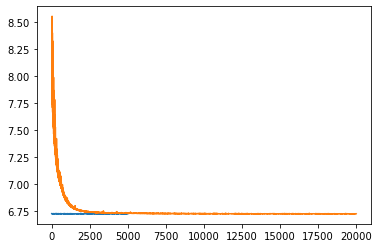

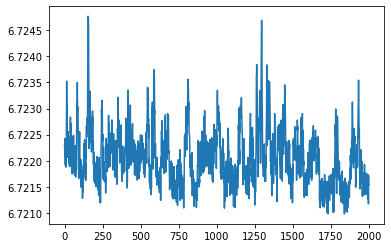

Sampling from posterior distribution...
Done.


In [3]:
results = cc.run_countcorrect(counts_geneProbes, counts_negativeProbes, counts_nuclei, slide_id = names_slides)

The output is a dictionary, with corrected raw counts, as well as corrected normalized counts (Counts-Per-Million).
It also includes the model name used (single-slide or multi-slide).

In [4]:
results

{'Model Name': 'Multi-Slide',
 'RawCounts': array([[  0.,   0.,  35., ..., 168.,   0.,   0.],
        [  0.,   0.,  95., ..., 128.,   0.,   0.],
        [  0.,   0.,  34., ...,  81.,   0.,   0.],
        ...,
        [ 37.,  48.,  50., ..., 283.,  58.,  34.],
        [ 34.,  12.,  94., ..., 134.,  36.,  15.],
        [  6.,  16.,  77., ..., 205.,  47.,   8.]], dtype=float32),
 'NormCounts': array([[  0.        ,   0.        ,  36.51717998, ..., 175.28246099,
           0.        ,   0.        ],
        [  0.        ,   0.        , 106.75716476, ..., 143.84122915,
           0.        ,   0.        ],
        [  0.        ,   0.        ,  82.5852112 , ..., 196.74711803,
           0.        ,   0.        ],
        ...,
        [ 19.27102494,  25.00024675,  26.04192377, ..., 147.39729522,
          30.20863187,  17.7085094 ],
        [ 37.84779619,  13.35804609, 104.63802755, ..., 149.16484361,
          40.07413736,  16.69755693],
        [  4.04430693,  10.78481819,  51.9019377 , ...

In [7]:
rawCounts_corrected = results['RawCounts']